In [1]:
import sys
# print(sys.path)
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths


In [3]:
print(tf.__version__)

2.6.0


## Data Processing

In [4]:
def showVideo(path_to_file):
    clean_video = cv2.VideoCapture(path_to_file)

    if clean_video.isOpened() == False:
        print("Error opening video stream or file")

    while clean_video.isOpened():
        ret, frame = clean_video.read()
        if ret:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cv2.destroyAllWindows()


In [5]:
def getImagesFromVideo(path_to_file, k=0):
    clean_video = cv2.VideoCapture(path_to_file)
    ret, frame = clean_video.read()
    count = 0
    while ret:
        if k == 1:
            cv2.imwrite("dataset/anomaly_images/image_anomaly_{}.jpg".format(count), frame)
        else: 
            cv2.imwrite("dataset/images/image_{}.jpg".format(count), frame)
        ret, frame = clean_video.read()
        count += 1
    print("Done reading {} frames from file {}".format(count, path_to_file))

In [6]:
def getData(path_to_file, image_size, convert_color = 0):
    imagePaths = list (paths.list_images(path_to_file))
    data = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if convert_color == 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        data.append(image)
    data = np.array(data).astype('float32') / 255.
    print("Done creating data for file {}".format(path_to_file))
    visualize_sample = 0
    if visualize_sample == 1:
        cv2.imshow("data", data[0])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return data

In [7]:
path_video_clean_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi'
path_video_anomaly_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi'

# showVideo(path_video_anomaly_data)

getImagesFromVideo(path_video_clean_data)
getImagesFromVideo(path_video_anomaly_data, k = 1)


path_clean_images = 'dataset/images'
path_anomalous_images = 'dataset/anomaly_images'



Done reading 221 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi
Done reading 161 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi


## Autoencoder

In [29]:
class AnomalyDetector(Model):
    def __init__(self, image_size, latentDim, hidden_layer_1, hidden_layer_2, channels):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (image_size, image_size, channels)),
            tf.keras.layers.Conv2D(hidden_layer_1, (3, 3), padding = 'same', strides = 2), 
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(hidden_layer_2, (3, 3), padding = 'same', strides = 2), 
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(), 
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(hidden_layer_2, kernel_size=3, padding = 'same', strides = 2), 
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(hidden_layer_1, kernel_size=3, padding = 'same', strides = 2),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(channels, 3, padding = 'same', activation = 'sigmoid'),
            # tf.keras.layers.Conv2D(channels, (3, 3), activation = 'sigmoid', padding = 'same')
        ]) 

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




In [30]:
def splitDataAutoencoder(data):
    train_data, test_data = train_test_split(data, test_size = 0.2, random_state=42)
    train_data = tf.cast(train_data, tf.float32)
    test_data = tf.cast(test_data, tf.float32)
    if data.shape[-1] != 3:
        train_data = train_data[..., tf.newaxis]
        test_data = test_data[..., tf.newaxis]
    return train_data, test_data

    

In [31]:
def trainModel(model, epochs, batch_size, optimizer, loss, metrics):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    history = model.fit(
        normal_train_data, normal_train_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(normal_test_data, normal_test_data),
        shuffle=True
    )
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

    print(model.encoder.summary())
    print(model.decoder.summary())

    return history


In [44]:
def plotDifferences(test_data, test_anomaly_data, n):
    encoded_data = autoencoder.encoder(test_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()

    encoded_anomaly_data = autoencoder.encoder(test_anomaly_data).numpy()
    decoded_anomaly_data = autoencoder.decoder(encoded_anomaly_data).numpy()

    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(tf.squeeze(test_data[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_data[i], test_data[i])))

        bx = plt.subplot(4, n, i + n + 1)
        plt.imshow(tf.squeeze(decoded_data[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
        bx.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_data[i], decoded_data[i])))

        cx = plt.subplot(4, n, i + 2*n + 1)
        plt.imshow(tf.squeeze(test_data[-i -1]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)
        cx.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_data[i], test_data[-i -1])))
        
        
        dx = plt.subplot(4, n, i + 3*n + 1)
        plt.imshow(tf.squeeze(test_anomaly_data[i]))
        plt.gray()
        dx.get_xaxis().set_visible(False)
        dx.get_yaxis().set_visible(False)
        dx.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_data[i], decoded_anomaly_data[i])))
    plt.show()

In [33]:
def evaluateLosses(data):
    reconstruction = autoencoder.predict(data)
    train_loss = tf.keras.losses.mae(reconstruction, data)

    train_loss_image = []
    for i in range(len(train_loss)):
        loss_image = np.sum(train_loss[i]) / 255
        train_loss_image.append(loss_image)

    plt.hist(train_loss_image, bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()
    return train_loss_image


In [34]:
# structural similarity between two images in terms of luminance, contrast and structure./
# A value of 1 indicates identical images -> SSIMLoss needs to be minimum (as close as possible to 0)
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

Done creating data for file dataset/images
Done creating data for file dataset/anomaly_images
Epoch 1/10
22/22 [==============================] - 39s 2s/step - loss: 0.3451 - mse: 0.0278 - val_loss: 0.2592 - val_mse: 0.0189
Epoch 2/10
22/22 [==============================] - 35s 2s/step - loss: 0.2071 - mse: 0.0114 - val_loss: 0.1592 - val_mse: 0.0044
Epoch 3/10
22/22 [==============================] - 36s 2s/step - loss: 0.1430 - mse: 0.0041 - val_loss: 0.1415 - val_mse: 0.0038
Epoch 4/10
22/22 [==============================] - 38s 2s/step - loss: 0.1235 - mse: 0.0035 - val_loss: 0.1183 - val_mse: 0.0035
Epoch 5/10
22/22 [==============================] - 34s 2s/step - loss: 0.1074 - mse: 0.0031 - val_loss: 0.1053 - val_mse: 0.0031
Epoch 6/10
22/22 [==============================] - 36s 2s/step - loss: 0.0962 - mse: 0.0028 - val_loss: 0.0898 - val_mse: 0.0022
Epoch 7/10
22/22 [==============================] - 42s 2s/step - loss: 0.0822 - mse: 0.0020 - val_loss: 0.0735 - val_mse: 0.0

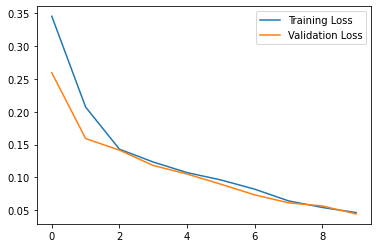

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 256)       7168      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       295040    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
Total params: 302,208
Trainable params: 302,208
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 128)       147584    
___________________

In [40]:
image_size = 128
data = getData(path_clean_images, image_size, convert_color = 0)
data_anomaly = getData(path_anomalous_images, image_size, convert_color = 0)

normal_train_data, normal_test_data = splitDataAutoencoder(data)
anomalous_train_data, anomalous_test_data = splitDataAutoencoder(data_anomaly)

epochs = 10
batch_size = 8
latentDim = 32
hidden_layer_1 = 256
hidden_layer_2 = 128
optimizer = 'adam'
loss = SSIMLoss
metrics = ['mse']
if data.shape[-1] != 3:
    channels = 1
else:
    channels = 3
    
autoencoder = AnomalyDetector(image_size=image_size, latentDim=latentDim, hidden_layer_1 = hidden_layer_1, hidden_layer_2 = hidden_layer_2, channels=channels)

history_autoencoder = trainModel(autoencoder, epochs=epochs, batch_size=batch_size, optimizer=optimizer, loss = loss, metrics = metrics)

autoencoder.save("./models/autoencoder")

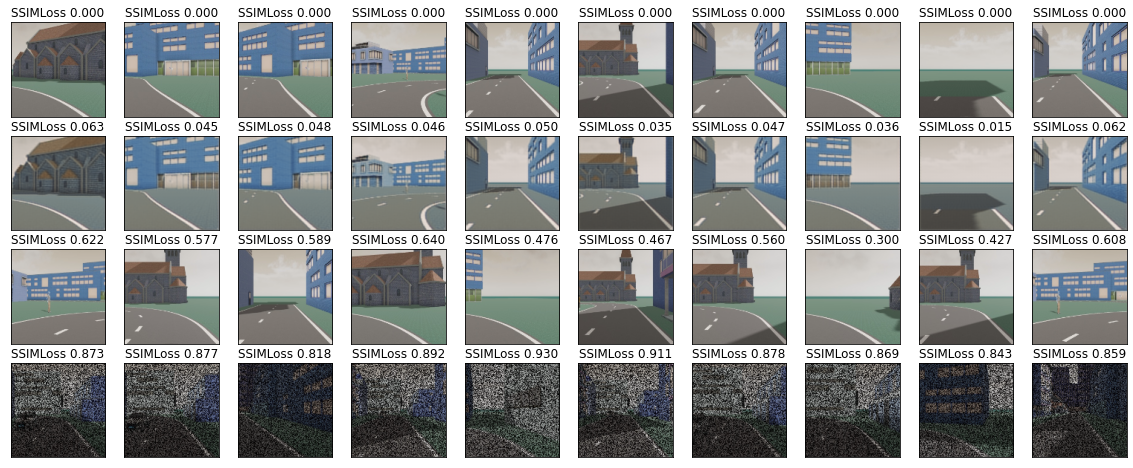

In [46]:
plotDifferences(normal_test_data, anomalous_test_data, 10)

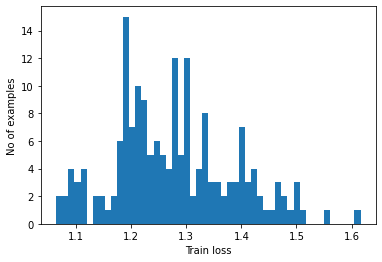

1.3838450772177826


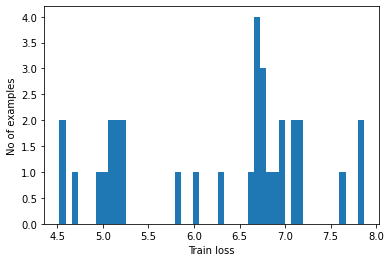

4.522443704044117


In [37]:
train_loss_image = evaluateLosses(normal_train_data)
threshold = np.mean(train_loss_image) + np.std(train_loss_image)
print(threshold)
test_loss_image = evaluateLosses(anomalous_test_data)
print(np.min(test_loss_image))

## Supervised Learning

In [8]:
image_size = 128
data = getData(path_clean_images, image_size, convert_color=0)
data_anomaly = getData(path_anomalous_images, image_size, convert_color=0)
X = np.concatenate((data, data_anomaly), axis = 0)
y = np.concatenate((np.zeros((len(data))), np.ones((len(data_anomaly)))), axis = 0)

Done creating data for file dataset/images
Done creating data for file dataset/anomaly_images


In [9]:
X_train, X_aux, y_train, y_aux = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, shuffle=True, stratify=y_aux, test_size=0.2, random_state = 42)

In [10]:
# def augmentImages(image, flip = False, rotation = False):
#     if flip == True:
#         data_augmentation = tf.keras.layers.experimental.preprocessing.RandomFlip()
#         return data_augmentation(image)
#     elif rotation == True:
#         data_augmentation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
#         return data_augmentation(image)

# augmented_data_flip = augmentImages(X_train, flip = True)
# augmented_data_rotation = augmentImages(X_train, rotation = True)
# X_train_augmented = np.concatenate((X_train, augmented_data_flip, augmented_data_rotation), axis = 0)
# y_train = np.concatenate((np.zeros((len(data))), np.ones((len(data_anomaly)))), axis = 0) 

In [24]:
def trainModelSL(hidden_convlayer_1, hidden_convlayer_2, hidden_denselayer_3, optimizer, loss, metrics, epochs, batch_size):
    supervised_model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.InputLayer(input_shape=(
            image_size, image_size, channels)),
        tf.keras.layers.Conv2D(hidden_convlayer_1, 3,
                               padding='same', strides=2, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(hidden_convlayer_2, 3,
                               padding='same', strides=2, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_denselayer_3, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    supervised_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    history_sup = supervised_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_val, y_val),
    )

    plt.plot(history_sup.history["loss"], label="Training Loss")
    plt.plot(history_sup.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

    plt.plot(history_sup.history["accuracy"], label="Training accuracy")
    plt.plot(history_sup.history["val_accuracy"], label="Validation accuracy")
    plt.legend()
    plt.show()

    print(supervised_model.summary())

    return history_sup, supervised_model


In [38]:
def plotPredictions(X_test, y_test, n, width = 20, height = 4):
    y_test_pred = supervised_model.predict(X_test)
    plt.figure(figsize=(width, height))
    if n > len(X_test):
        n = len(X_test)
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(tf.squeeze(X_test[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("True: {}, \n Predicted: {}".format(y_test[i], np.round(y_test_pred[i])[0]))

    plt.show()



Epoch 1/10
17/17 [==============================] - 7s 348ms/step - loss: 0.6717 - accuracy: 0.5543 - val_loss: 0.6401 - val_accuracy: 0.5870
Epoch 2/10
17/17 [==============================] - 5s 313ms/step - loss: 0.6011 - accuracy: 0.5768 - val_loss: 0.5606 - val_accuracy: 0.5870
Epoch 3/10
17/17 [==============================] - 4s 253ms/step - loss: 0.5566 - accuracy: 0.5843 - val_loss: 0.4830 - val_accuracy: 0.5870
Epoch 4/10
17/17 [==============================] - 4s 248ms/step - loss: 0.4580 - accuracy: 0.8090 - val_loss: 0.3557 - val_accuracy: 0.8804
Epoch 5/10
17/17 [==============================] - 5s 298ms/step - loss: 0.3479 - accuracy: 0.9363 - val_loss: 0.2026 - val_accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 4s 205ms/step - loss: 0.1647 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 3s 177ms/step - loss: 0.0432 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 

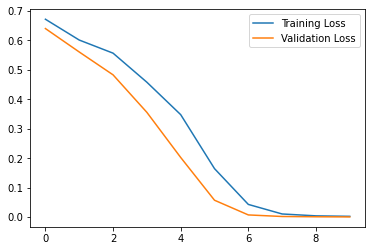

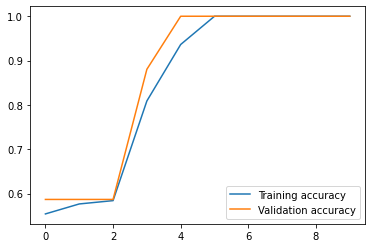

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_9 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_9 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
input_9 (InputLayer)         multiple                  0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 4)         292       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 4)          

In [25]:
hidden_convlayer_1 = 8 
hidden_convlayer_2 = 4
hidden_denselayer_3 = 16
optimizer = 'adam'
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
epochs = 10
batch_size = 16
channels = data.shape[-1]
history_supervised, supervised_model = trainModelSL(hidden_convlayer_1, hidden_convlayer_2, hidden_denselayer_3, optimizer, loss, metrics, epochs, batch_size)

In [351]:
test_loss, test_acc = supervised_model.evaluate(X_test, y_test, verbose = 2)

1/1 - 0s - loss: 6.7442e-07 - accuracy: 1.0000


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



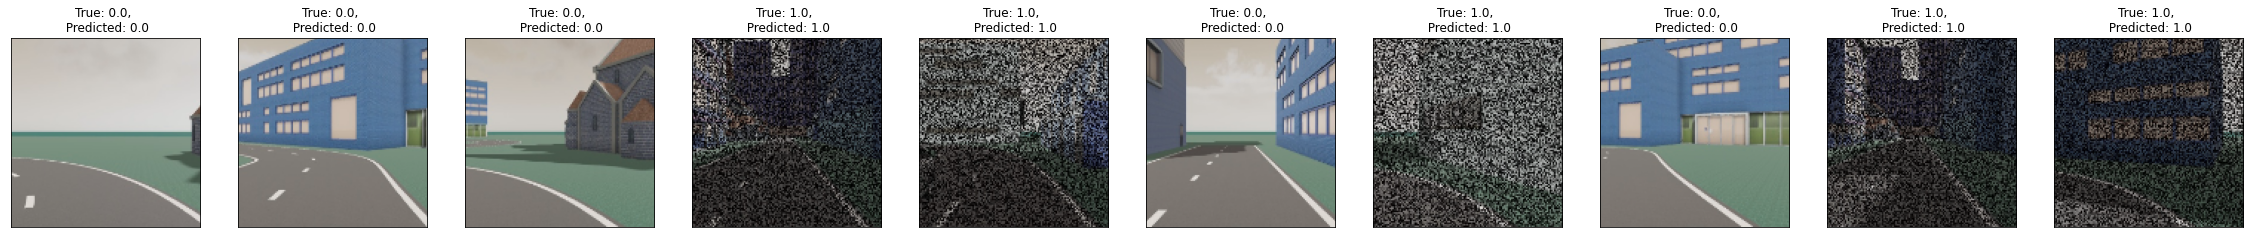

In [358]:
y_test_pred = supervised_model.predict(X_test)
print(classification_report(y_test, np.round(y_test_pred)))
plotPredictions(X_test, y_test, 10, 40, 6)

In [28]:
supervised_model.save("./models/supervised_model")

INFO:tensorflow:Assets written to: ./models/supervised_model/assets
